In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile,ClassicalRegister,QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator

Oracle Circuit for marked state |111>:


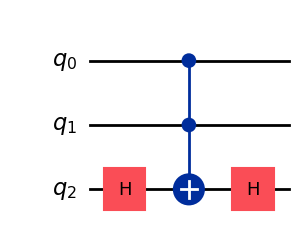


Grover Operator (initial decomposition):


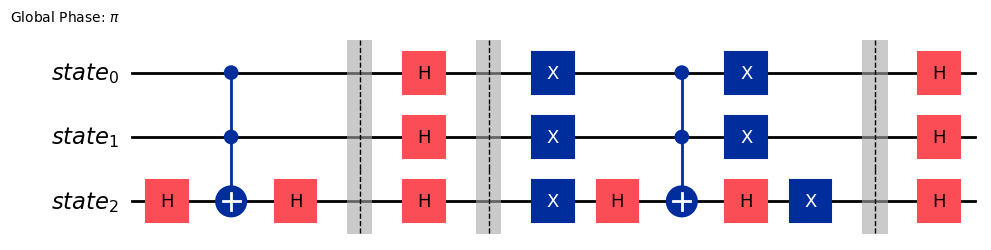


Full Grover Circuit:


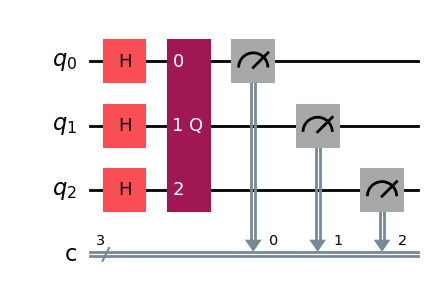


Fully decomposed Grover Circuit using .decompose() method:


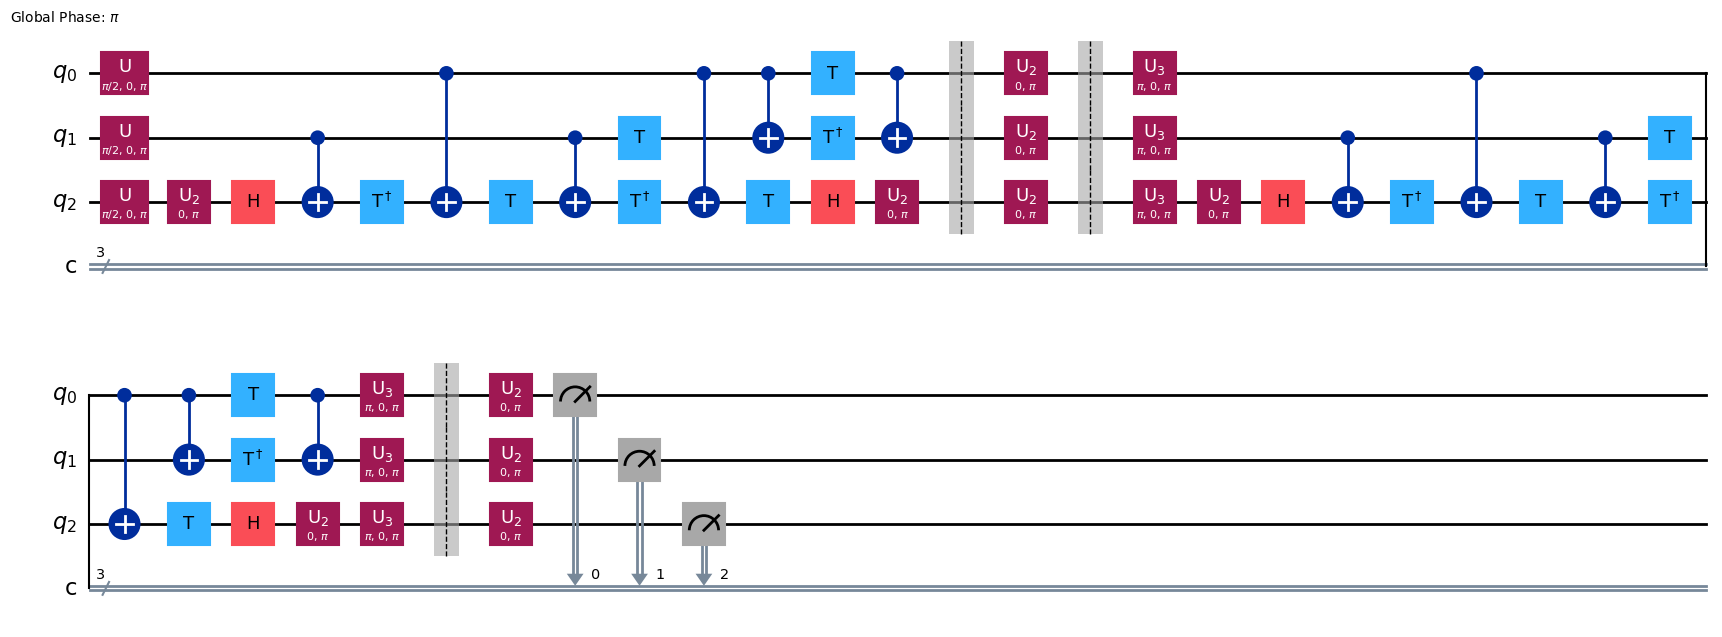


Transpiled Grover Circuit to basis gates ['u3', 'cx']:


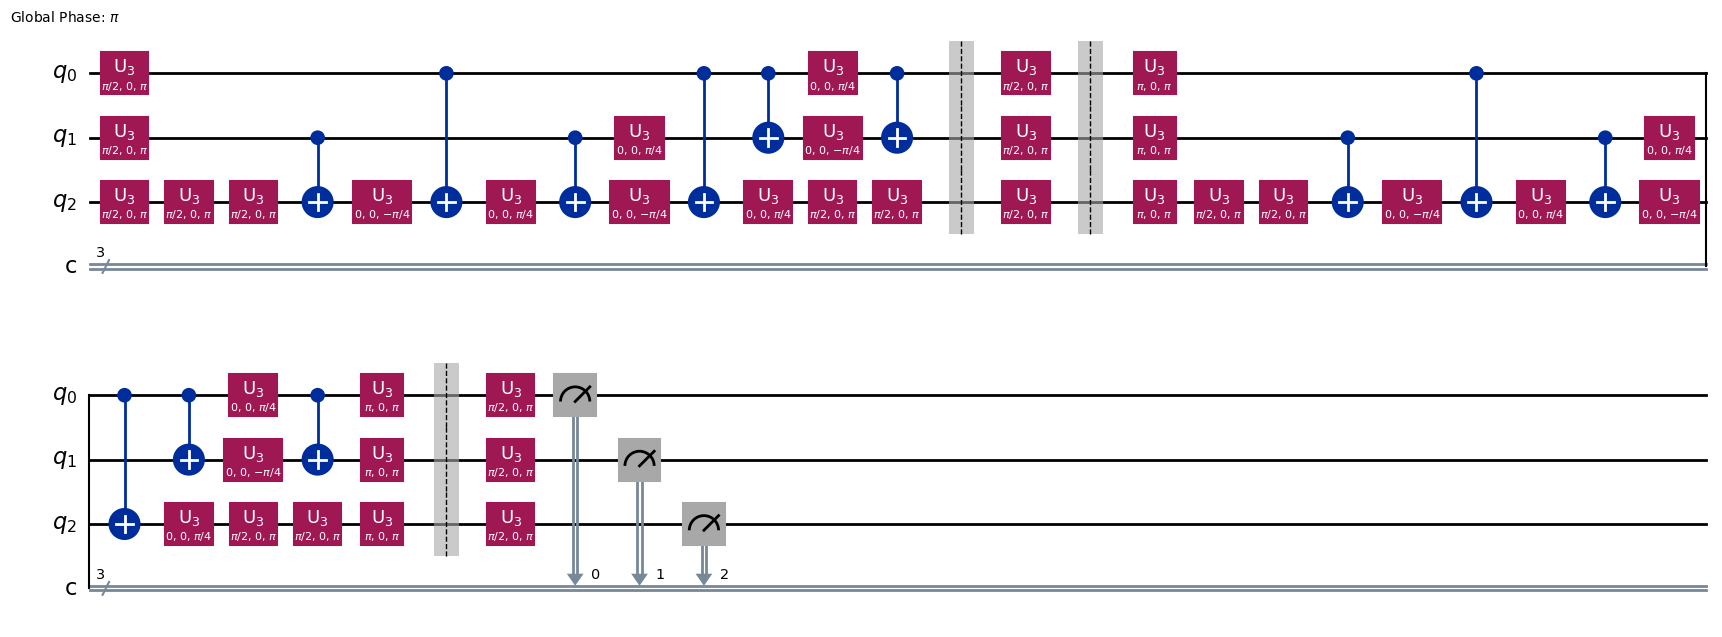

In [2]:
# ------------------------------------------------------------------------------
# Helper Function: Construct a Phase Oracle for the Given Marked State
# ------------------------------------------------------------------------------
def construct_oracle(marked_state: str) -> QuantumCircuit:
    """
    Constructs an oracle circuit that flips the phase of the given marked state.
    
    The routine works as follows:
      1. For every qubit where the marked state bit is '0', apply an X gate.
      2. Apply an H gate on the last qubit.
      3. Apply a multi-controlled X (MCX) with controls on all qubits except the last one.
      4. Apply another H gate on the last qubit.
      5. Undo the X gates from step 1.
      
    For example, for marked_state "101" on a 3-qubit circuit, an X gate is applied to
    qubit 1 (since the corresponding bit is '0'). This converts |101> to |111> for the
    oracle routine, and then the phase flip is applied only on that state.
    """
    n = len(marked_state)
    oracle = QuantumCircuit(n, name='oracle')
    
    # 1. Apply X gates on qubits corresponding to '0' in marked_state.
    for q in range(n):
        if marked_state[q] == '0':
            oracle.x(q)
    
    # 2. Use the last qubit as the target for a multi-controlled Z gate.
    #    This is implemented via an H, MCX, H sandwich.
    oracle.h(n-1)
    if n > 1:
        controls = list(range(n-1))
        target = n-1
        oracle.mcx(controls, target)
    else:
        # For a single qubit, a simple Z gate is sufficient.
        oracle.z(0)
    oracle.h(n-1)
    
    # 3. Uncompute the X gates.
    for q in range(n):
        if marked_state[q] == '0':
            oracle.x(q)
            
    return oracle

# ------------------------------------------------------------------------------
# 1. Choose Your Marked State and Build the Oracle
# ------------------------------------------------------------------------------
# Set the marked state as a string, for example "101".
marked_state = "111"
oracle = construct_oracle(marked_state)

# Visualize the Oracle Circuit.
print("Oracle Circuit for marked state |{}>:".format(marked_state))
display(oracle.draw('mpl'))

# ------------------------------------------------------------------------------
# 2. Create the Grover Operator Using the Oracle
# ------------------------------------------------------------------------------
# The default state preparation is H⊗n (Hadamard on each qubit).
grover_op = GroverOperator(oracle, insert_barriers=True)
print("\nGrover Operator (initial decomposition):")
display(grover_op.decompose().draw('mpl'))

# ------------------------------------------------------------------------------
# 3. Build the Full Grover Circuit
# ------------------------------------------------------------------------------
n = len(marked_state)  # Number of qubits
qc = QuantumCircuit(n, n)
qc.h(range(n))                 # State preparation: uniform superposition
qc.append(grover_op, range(n))   # Apply one Grover iteration
qc.measure(range(n), range(n))   # Measurement

print("\nFull Grover Circuit:")
display(qc.draw('mpl'))

# ------------------------------------------------------------------------------
# 4. Method 1: Repeated Decomposition Using .decompose()
# ------------------------------------------------------------------------------
# Decompose the circuit repeatedly until only primitive gates remain.
qc_decomposed = qc.decompose().decompose().decompose()
print("\nFully decomposed Grover Circuit using .decompose() method:")
display(qc_decomposed.draw('mpl'))

# ------------------------------------------------------------------------------
# 5. Method 2: Transpile to Unroll All Gates to a Specific Basis
# ------------------------------------------------------------------------------
# Here, we transpile the circuit to the basis gates 'u3' and 'cx' so that you
# can see the low-level gate implementation.
basis_gates = ['u3', 'cx']
qc_transpiled = transpile(qc, basis_gates=basis_gates, optimization_level=0)
print("\nTranspiled Grover Circuit to basis gates {}:".format(basis_gates))
display(qc_transpiled.draw('mpl'))


Measurement Results:


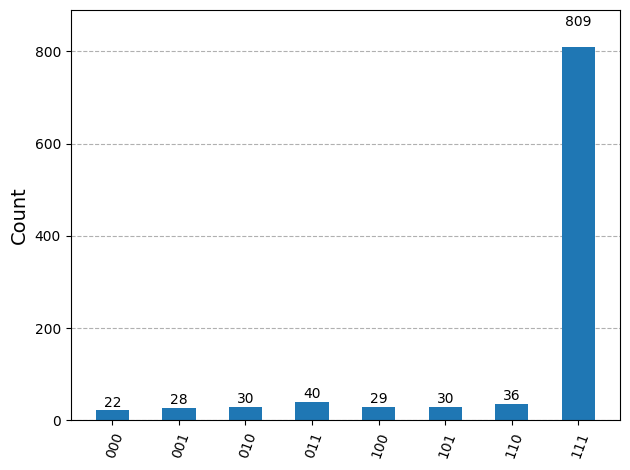

In [3]:
# ------------------------------------------------------------------------------
# 6. Run the Circuit on the QASM Simulator and Plot the Histogram
# ------------------------------------------------------------------------------
simulator = QasmSimulator()
compiled_circuit = transpile(qc, simulator, optimization_level=0)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts()
print("\nMeasurement Results:")
display(plot_histogram(counts))